In [1]:
%matplotlib inline

import cv2
import imageio
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import trim_mean
from sklearn.cluster import DBSCAN

plt.rcParams.update({'font.size': 2})

In [2]:
def apply_canny(image, threshold1=100, threshold2=230):
    return cv2.Canny(np.uint8(image), threshold1=threshold1, threshold2=threshold2)

# Takes a list of (x, y) coordinates corresponding to points in the cluster. This
# cluster is presumed to be INaccurate, so we trim the tails to remove outliers.
def compute_approx_centroid(cluster):
    y = int(trim_mean(cluster[:, 0], 0.25))
    x = int(trim_mean(cluster[:, 1], 0.25))
    return x, y

# Takes a list of (x, y) coordinates corresponding to points in the cluster. This
# cluster is presumed to be accurate, so we use all values given.
# Output:
#  - x, y: the centroid
#  - box_x: x distance from the centroid for the bounding box
#  - box_y: y distance from the centroid for the bounding box
def compute_centroid_and_box(cluster):
    x = int(np.mean(cluster[:, 1]))
    size_x = np.max(cluster[:, 1]) - np.min(cluster[:, 1])
    box_x = int(1.5*size_x)

    y = int(np.mean(cluster[:, 0]))
    size_y = np.max(cluster[:, 0]) - np.min(cluster[:, 0])
    box_y = int(1.5*size_y)
    
    return x, y, box_x, box_y

def display_centroids(image, cells, dpi=150, save_name=None):
    plt.figure(dpi=dpi)
    plt.imshow(image, interpolation='nearest', cmap='gray')
    plt.scatter(*zip(*cells[:,0:2]), c='r', marker='+')
    if save_name is not None:
        plt.savefig('saved_images/' + save_name + '.png', bbox_inches='tight')
    else:
        plt.show()
    
def display_image_array(im_arr, columns=7, dpi=240):
    rows = int(len(im_arr) / columns) + 1
    plt.figure(dpi=dpi)
    for i in range(len(im_arr)):
        plt.subplot(rows,columns,i+1)
        plt.imshow(im_arr[i], interpolation='nearest', cmap='gray')
    plt.show()

def get_sub_images(image, cells):
    boxes = []
    for i in range(len(cells)):
        x, y, box_x, box_y = cells[i]
        box = image[max(y-box_y, 0):min(y+box_y, image.shape[0]),
                    max(x-box_x, 0):min(x+box_x, image.shape[1])]
        boxes += [box,]
    return boxes

# Input:
#  - image: binary image
#  - threshold [0-1]: only remove elements less that make up less than threshold
#                     amount of total elements
#  - connectivity: 4 to exclude diagonals, 8 to include
def remove_border_elements(image, threshold=0.4, connectivity=8):
    num_components, labelled, stats, centroids = \
        cv2.connectedComponentsWithStats(image, connectivity, cv2.CV_32S) 
    total_size = sum(stats[1:,-1])  # label 0 is the background component

    border_filter = np.ones(labelled.shape).astype(int)
    border_filter[1:-1, 1:-1] = 0

    for c in range(1, num_components):  # label 0 is the background component
        component = (labelled == c).astype(int)
        if np.sum(component & border_filter) > 0 and \
           np.sum(component) < threshold*total_size:
            image = image & (1-component)
    
    return image

# Using new_image, update the centroids in cells. Note that this modifies
# cells in-place.
def update_tracking(new_image, cells, debug=False):
    new_image = apply_canny(new_image)
    
    for i in range(len(cells)):
        x, y, box_x, box_y = cells[i]
        
        # box should not exceed bounds of image
        box = new_image[max(y-box_y, 0):min(y+box_y, new_image.shape[0]),
                        max(x-box_x, 0):min(x+box_x, new_image.shape[1])]

        if len(box) == 0:
            continue
        filtered = remove_border_elements(box)
        cluster = np.argwhere(filtered)
        
        # Need to ensure cell is inside the box
        if len(cluster) > 0:
            sub_x, sub_y = compute_approx_centroid(cluster)
            
            if debug:
                display_centroids(box, [[sub_x, sub_y],], dpi=50)
                display_centroids(filtered, [[sub_x, sub_y],], dpi=50)

            cells[i][0] = max(x-box_x, 0) + sub_x
            cells[i][1] = max(y-box_y, 0) + sub_y
        else:
            if debug:
                plt.figure(dpi=dpi)
                plt.imshow(box, interpolation='nearest', cmap='gray')
                plt.show()

# Read initial image and find centroids

Image dimensions: (832, 1128)


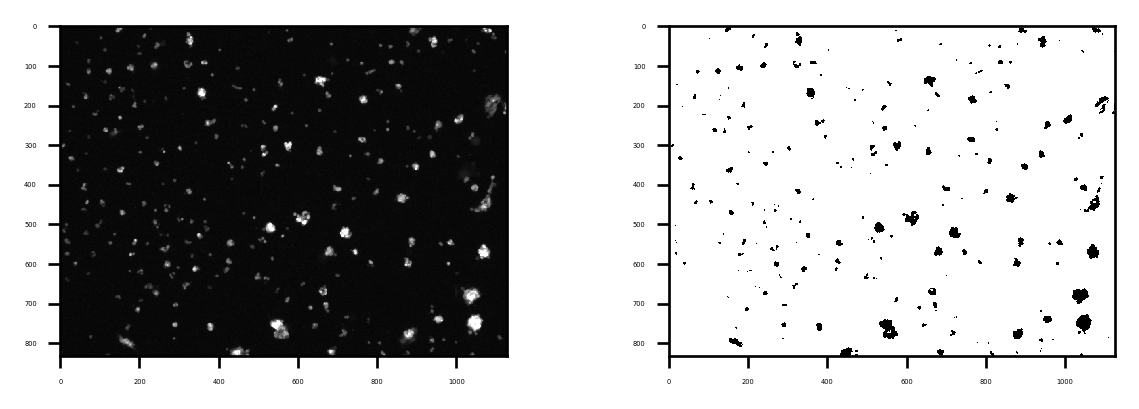

In [3]:
rfp = cv2.imreadmulti('RFP-1.tif')[1]

initial_image = rfp[0]

# 0 is a throwaway param, Otsu will determine
threshold, binarized = \
    cv2.threshold(initial_image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
initial_binarized = (initial_image < threshold).astype(int)  # sets a higher threshold

coordinate_bounds = initial_image.shape
print("Image dimensions: " + str(coordinate_bounds))

display_image_array([initial_image, initial_binarized], columns=2)

Tracking 58 cells


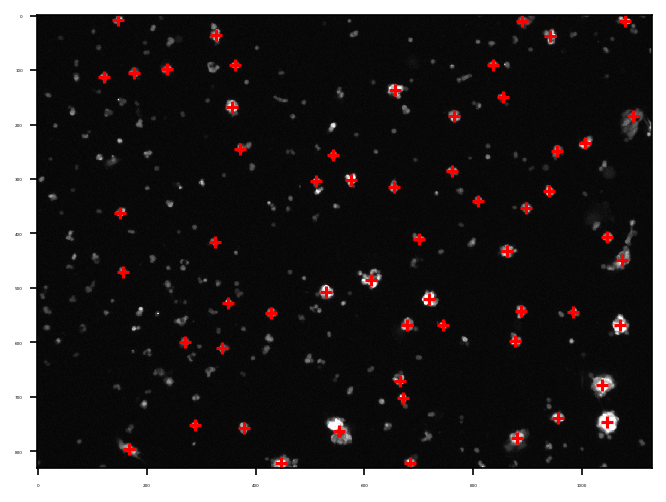

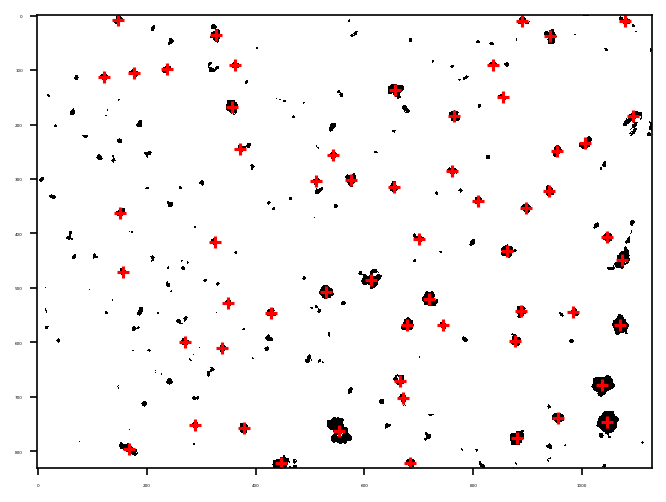

In [4]:
cell_points = np.argwhere(1-initial_binarized)
clustering = DBSCAN(eps=6, min_samples=100).fit(cell_points)
labels = clustering.labels_

# Store cells as [[centroid, box_x, box_y], ...]
cells = []

# Note that clustering.labels_ includes -1, which are noisy samples.
# Thus, enforce starting at 0 rather than min(labels).
for i in range(0, max(labels)+1):
    indices = np.where(labels == i)
    cluster = cell_points[indices]
    x, y, box_x, box_y = compute_centroid_and_box(cluster)
    cells += [[x, y, box_x, box_y],]
    
cells = np.array(cells)

print("Tracking %i cells" % len(cells))
display_centroids(initial_image, cells)
display_centroids(initial_binarized, cells)

# Iterate on all images

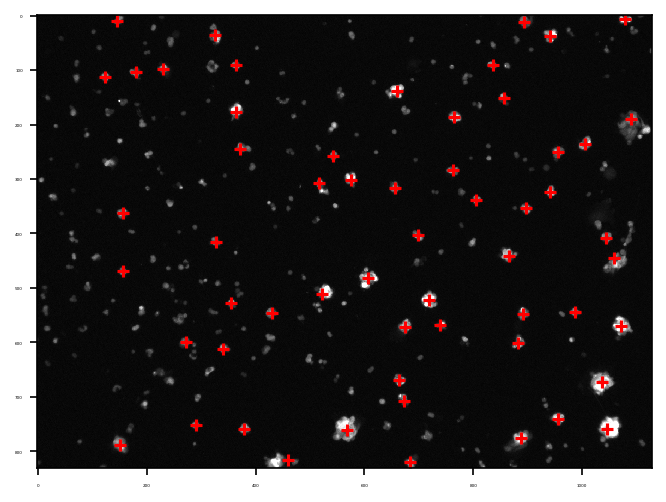

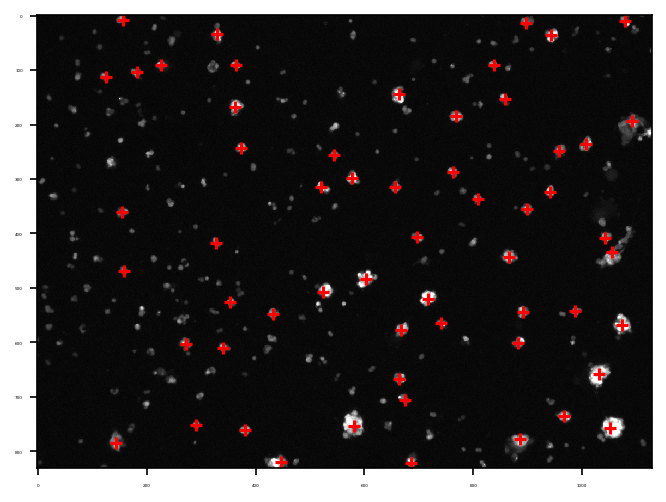

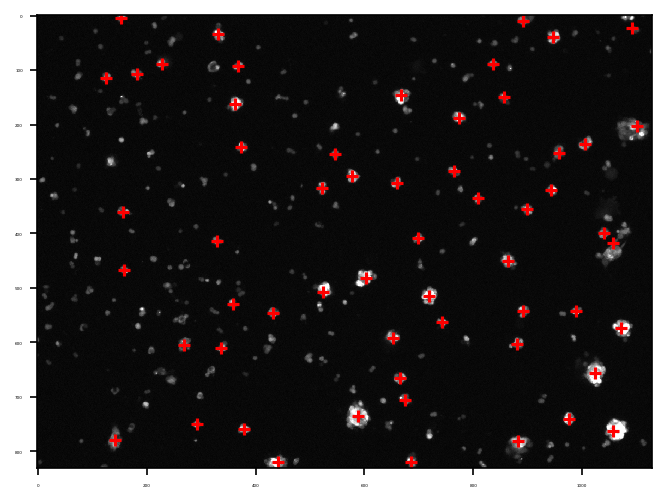

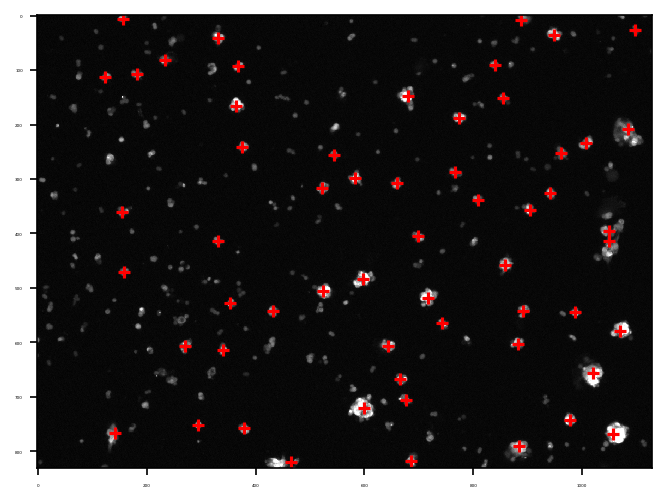

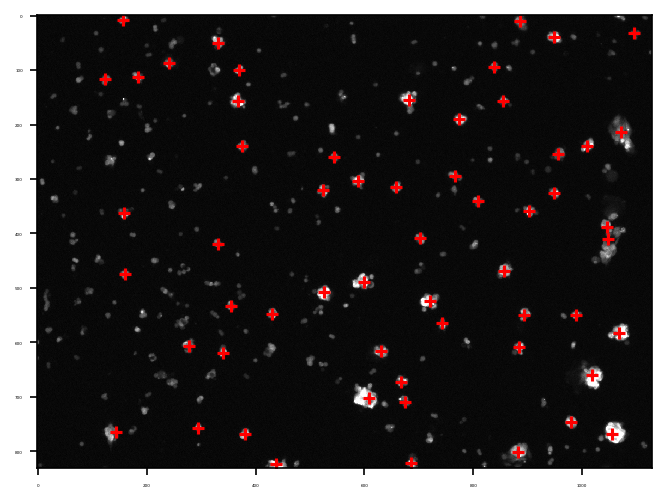

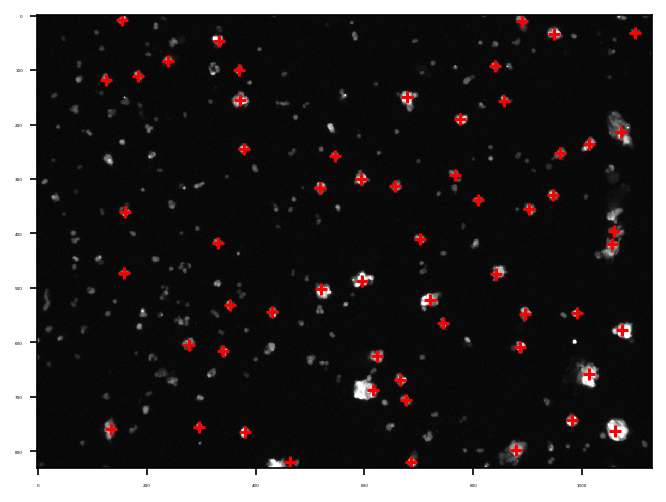

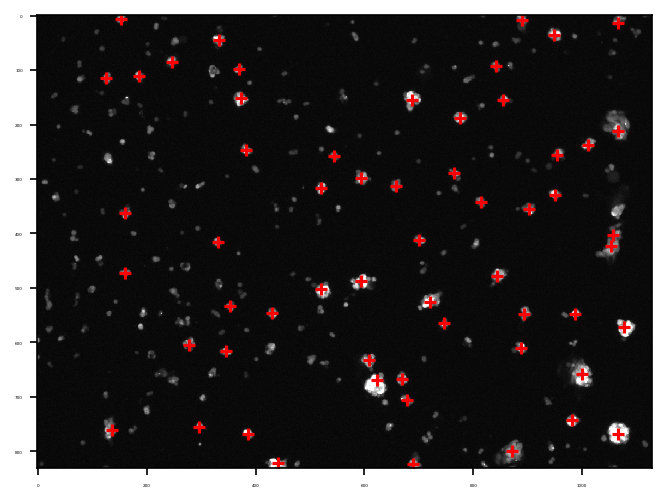

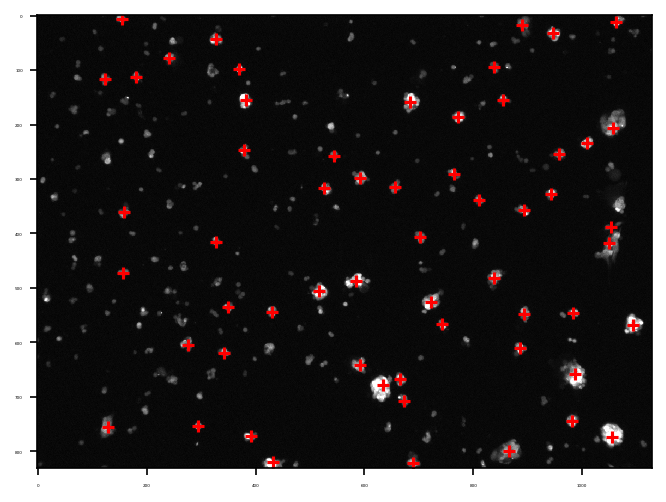

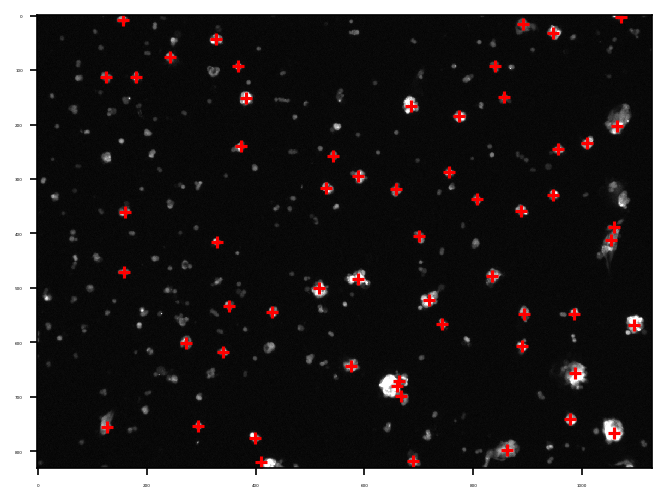

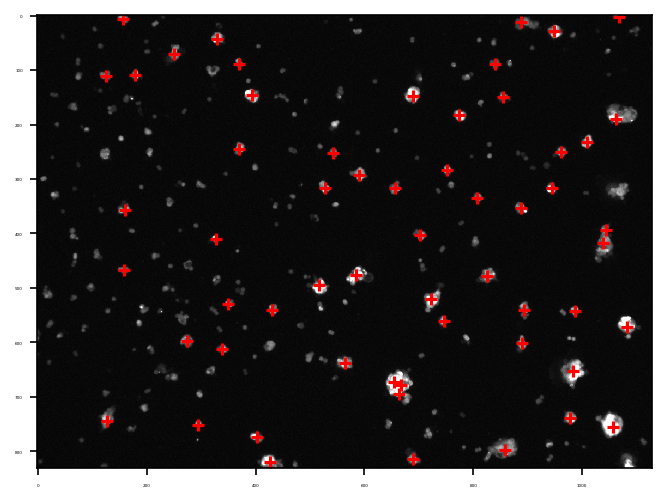

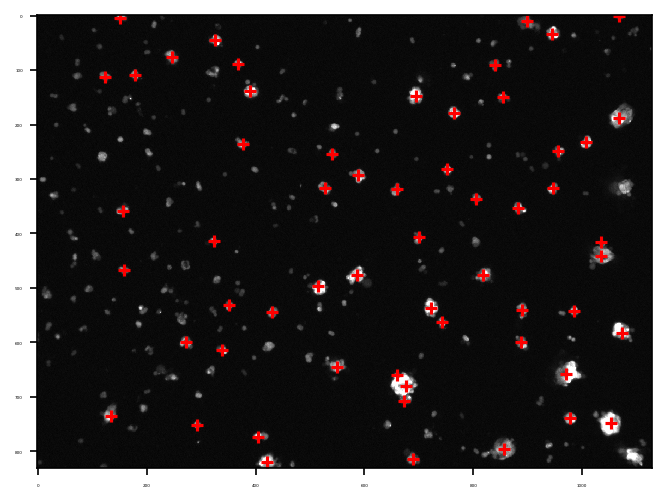

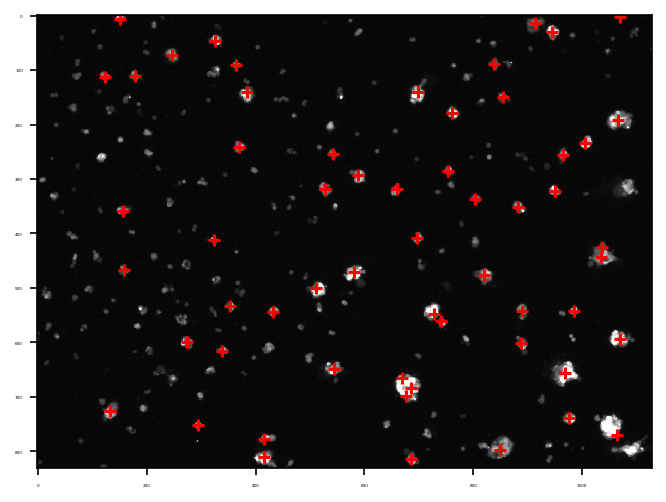

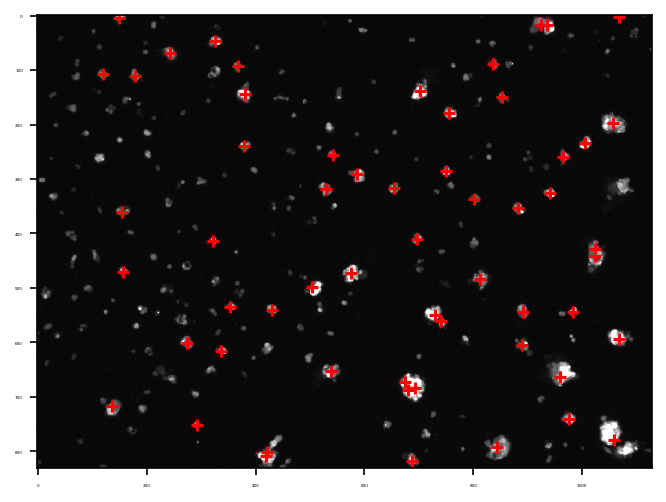

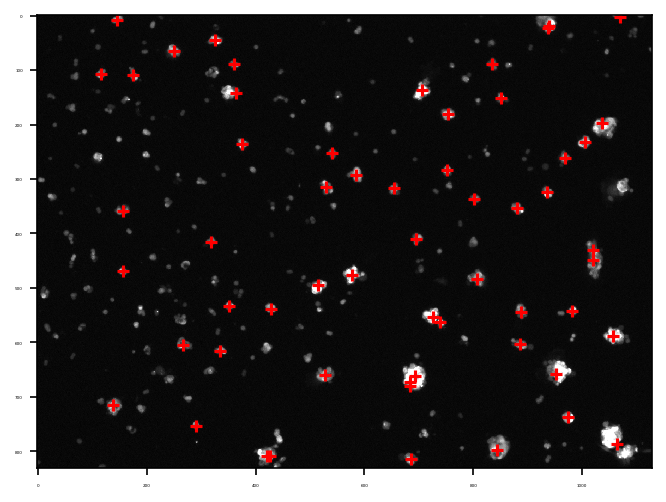

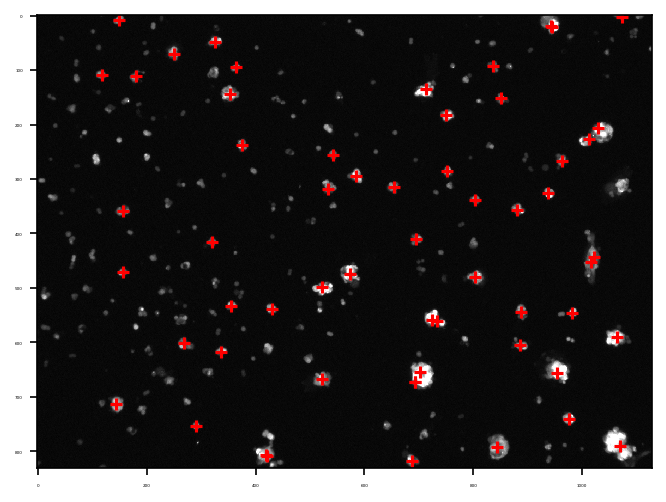

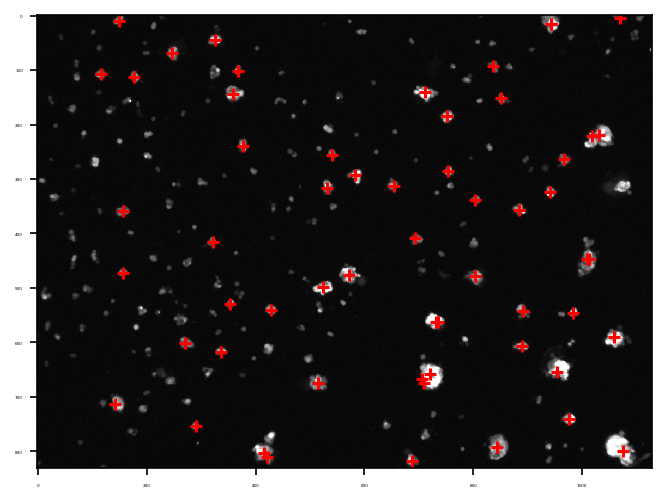

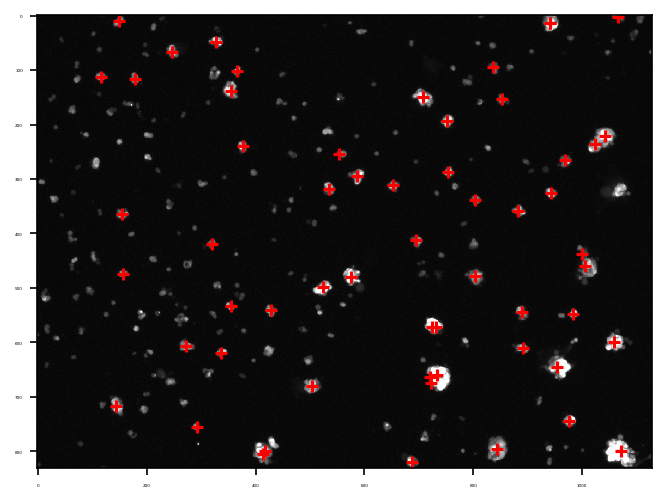

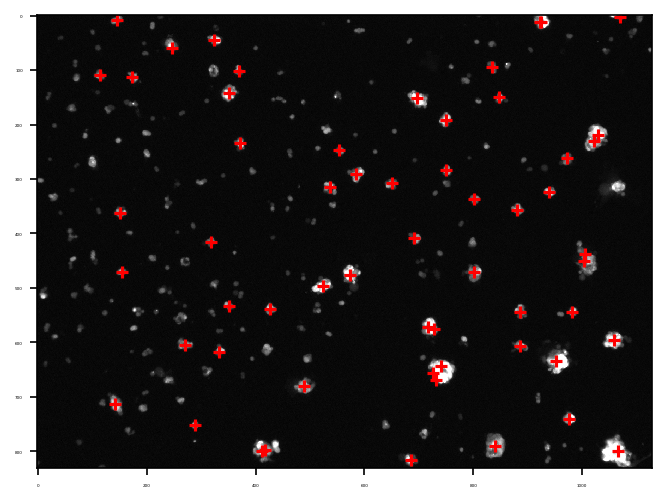

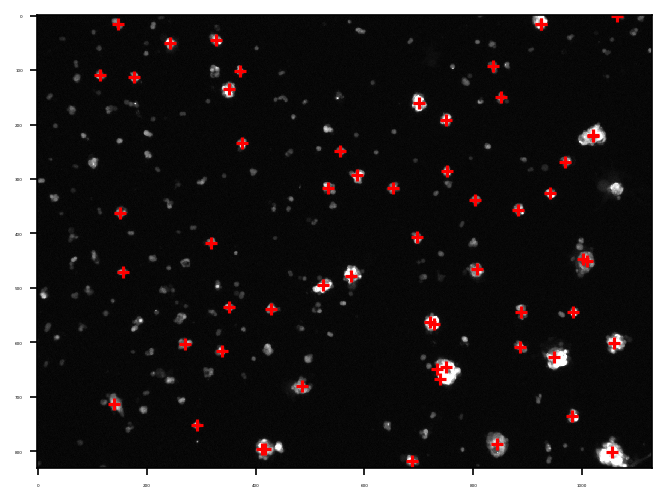

In [5]:
for i in range(1, 20): # len(rfp)):
    image = rfp[i]
    update_tracking(image, cells, debug=False)
    display_centroids(image, cells) # , save_name=str(i))

# Pipeline sanity check

# Proof of Concept for LoG and Canny